In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from tqdm import tqdm
from ryu_tool import mytool
from ryu_tool.min_variance import PortfolioOptimzer

In [2]:
# 필요한 파일을 불러옵니다
stock_price = pd.read_pickle("Data/allstock_reduced.pickle")
spy_mask = pd.read_pickle("Data/spx_mask.pickle")

In [33]:
stock_price

PERMNO,10225,14702,10942,38578,42083,50876,60442,82959,19502,75789,...,22976,17307,88182,17942,16581,86288,12476,82276,23569,84262
date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,32.2500,126.5000,153.9375,30.9375,25.1250,65.56250,42.18750,45.1250,28.5625,44.500,...,NaN,NaN,NaN,NaN,NaN,31.37500,NaN,11.5000,NaN,15.9375
2000-01-04,31.6875,120.2500,135.9375,30.7500,24.7500,63.12500,40.87500,44.4375,27.5000,43.750,...,NaN,NaN,NaN,NaN,NaN,32.37500,NaN,11.4375,NaN,15.0625
2000-01-05,31.8750,115.7500,136.0000,30.6250,24.2500,64.31250,41.06250,46.0625,27.8125,43.750,...,NaN,NaN,NaN,NaN,NaN,31.43750,NaN,12.5000,NaN,16.1875
2000-01-06,32.1875,115.9375,125.8750,31.0000,25.1875,66.18750,43.00000,48.2500,27.0000,45.875,...,NaN,NaN,NaN,NaN,NaN,31.00000,NaN,12.3750,NaN,16.3750
2000-01-07,32.2500,116.9375,139.0000,32.0625,25.8125,71.06250,43.06250,47.9375,27.6875,47.500,...,NaN,NaN,NaN,NaN,NaN,30.53125,NaN,13.0625,NaN,16.9375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,NaN,97.2200,NaN,NaN,NaN,367.89999,155.02000,NaN,38.6300,NaN,...,9.17,32.67,62.39,36.37,29.90,76.89000,73.36,63.3800,28.04,102.5900
2022-12-27,NaN,95.3400,NaN,NaN,NaN,364.88000,155.96001,NaN,38.3100,NaN,...,9.23,32.72,61.36,36.10,29.73,76.75000,73.89,63.6200,28.94,102.9000
2022-12-28,NaN,94.2250,NaN,NaN,NaN,365.22000,155.86000,NaN,37.5800,NaN,...,8.87,32.19,60.28,35.77,29.11,76.05000,71.95,62.6000,28.14,99.8900


In [24]:
corr = stock_price.loc["2022"].dropna(axis=1).corr()

In [32]:
corr

PERMNO,14702,50876,60442,19502,70092,77606,59176,43350,64995,66181,...,89781,79452,17307,88182,17942,16581,86288,12476,82276,84262
PERMNO,,,,,,,,,,,,,,,,,,,,,
14702,1.000000,-0.703782,0.920031,0.948138,0.927320,0.776815,0.823283,0.890079,0.927998,0.850850,...,-0.302697,0.817599,-0.518586,-0.019700,0.237277,0.723302,-0.129818,-0.137081,-0.113386,-0.331779
50876,-0.703782,1.000000,-0.789019,-0.704146,-0.722719,-0.782627,-0.682946,-0.879990,-0.809853,-0.482872,...,0.437571,-0.839750,0.698426,0.367339,-0.125212,-0.817048,0.528887,0.372525,0.637906,0.771002
60442,0.920031,-0.789019,1.000000,0.877202,0.901700,0.749515,0.798071,0.912788,0.976377,0.829200,...,-0.278692,0.816468,-0.557552,-0.054012,0.338207,0.782432,-0.107631,-0.306096,-0.240245,-0.506456
19502,0.948138,-0.704146,0.877202,1.000000,0.909560,0.816004,0.760938,0.912485,0.898058,0.801123,...,-0.449874,0.817321,-0.601149,-0.228580,0.123863,0.708451,-0.252894,-0.158115,-0.131976,-0.362138
70092,0.927320,-0.722719,0.901700,0.909560,1.000000,0.692963,0.702670,0.888788,0.903106,0.877227,...,-0.352224,0.751619,-0.497352,-0.096332,0.245218,0.690029,-0.140812,-0.286517,-0.140652,-0.435869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16581,0.723302,-0.817048,0.782432,0.708451,0.690029,0.749928,0.747534,0.846114,0.749512,0.526211,...,-0.250704,0.923792,-0.452062,-0.243170,0.283130,1.000000,-0.376232,-0.148676,-0.604290,-0.576807
86288,-0.129818,0.528887,-0.107631,-0.252894,-0.140812,-0.493270,-0.229517,-0.432296,-0.174600,0.221978,...,0.549176,-0.500764,0.581734,0.765099,0.448049,-0.376232,1.000000,0.070823,0.666000,0.532564
12476,-0.137081,0.372525,-0.306096,-0.158115,-0.286517,0.072125,0.188768,-0.316506,-0.243332,-0.296388,...,0.443985,-0.074222,0.224998,0.174656,0.040407,-0.148676,0.070823,1.000000,0.406640,0.732907


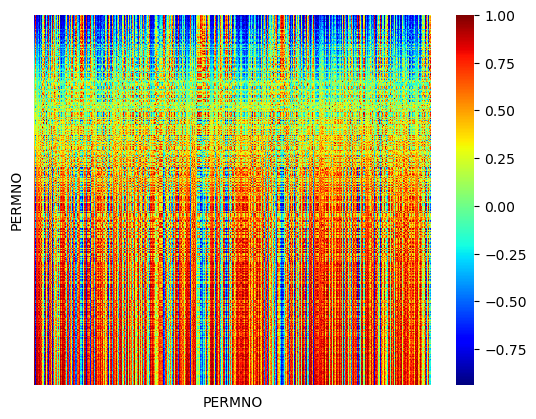

In [31]:
import seaborn as sns 

sns.heatmap(corr_s,
            cmap="jet",
            xticklabels=False,
            yticklabels=False);

In [ ]:
portfolio = PortfolioOptimzer(price=stock_price,
                              spx_mask=spy_mask)

In [ ]:
pf_rtn, weight_df = portfolio.run_optimizer(start_year="2020",
                                            end_year="2023",
                                            rebalancing="Q",
                                            shrinkage_method="clipping",
                                            args={"k":5})

In [ ]:
mytool.draw_return_result({"title": pf_rtn})

In [ ]:
weight_df.iloc[:,:100].plot(figsize=(24,12))